# 3D Image Segmentation with a 2D UNET

# 1) Imports and mount

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!python -c "import monai" || pip install -q "monai[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [3]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os.path
from os import path
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.inferers import SlidingWindowInferer

from monai.data import Dataset, DataLoader
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    MapTransform,
    Resized,
    Spacingd,
    ToTensord,
    Orientationd,
    Orientation,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Rand2DElasticd,
    RandZoomd
)

# 2) Helper Functions and Global Variables

In [4]:
ROOT_DIR = '/content/drive/MyDrive/Brain Health In COVID 19/'
SINGPORE_ONLY = False

#==============[START]Singapore Data==================
SINGAPORE_DIR = os.path.join(ROOT_DIR, 'Singapore/')

SINGAPORE_INPUT_DATA_DIR = os.path.join(SINGAPORE_DIR, 'Volumes/')
SINGAPORE_OUTPUT_DATA_DIR = os.path.join(SINGAPORE_DIR, 'Slices/')


SINGAPORE_INPUT_DATA_PATHS = [f.path for f in os.scandir(SINGAPORE_INPUT_DATA_DIR) if f.is_dir()] 
SINGAPORE_OUTPUT_DATA_PATHS = [f.path for f in os.scandir(SINGAPORE_OUTPUT_DATA_DIR) if f.is_dir()] 
#==============[END]Singapore Data==================


#==============[START]Utrecht Data==================
UTRECHT_DIR = os.path.join(ROOT_DIR, 'Utrecht/')

UTRECHT_INPUT_DATA_DIR = os.path.join(UTRECHT_DIR, 'Volumes/')
UTRECHT_OUTPUT_DATA_DIR = os.path.join(UTRECHT_DIR, 'Slices/')

UTRECHT_INPUT_DATA_PATHS = [f.path for f in os.scandir(UTRECHT_INPUT_DATA_DIR) if f.is_dir()] 
UTRECHT_OUTPUT_DATA_PATHS = [f.path for f in os.scandir(UTRECHT_OUTPUT_DATA_DIR) if f.is_dir()] 
#==============[END]Utrecht Data==================

#==============[START]Amsterdam Data==================
AMSTERDAM_DIR = os.path.join(ROOT_DIR, 'Amsterdam/')

AMSTERDAM_INPUT_DATA_DIR = os.path.join(AMSTERDAM_DIR, 'Volumes/')
AMSTERDAM_OUTPUT_DATA_DIR = os.path.join(AMSTERDAM_DIR, 'Slices/')

AMSTERDAM_INPUT_DATA_PATHS = [f.path for f in os.scandir(AMSTERDAM_INPUT_DATA_DIR) if f.is_dir()] 
AMSTERDAM_OUTPUT_DATA_PATHS = [f.path for f in os.scandir(AMSTERDAM_OUTPUT_DATA_DIR) if f.is_dir()] 
#==============[END]Amsterdam Data==================

HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNDFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = False
SLICE_Y = False
SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

In [5]:
class DataDict():
    ImageT1 = 'img_t1'
    ImageFlair = 'img_flair'
    Image = 'image'
    Label = 'label'
    Id = 'subj_id'
    CountryDirType = 'dir_type'
    DepthZ = 'depth_z'
    Prediction = 'prediction'

class CountryDirType():
    Singapore = 'Singapore'
    Utrecht = 'Utretcht'
    Amsterdam = 'Amsterdam'

def image_directories_handler(population_folder, dir_type):
    image_dict = []
    nifti_extension = '.nii.gz'
    for subject in population_folder:
        sub_id = int(os.path.basename(os.path.normpath(subject)))
        flair_img = subject + '/pre/' + 'FLAIR' + nifti_extension
        t1_img = subject + '/pre/' + 'T1' + nifti_extension
        label = subject + '/wmh.nii.gz' 
        
        subject_dict = { 
            DataDict.Id: sub_id,
            DataDict.ImageT1 : t1_img,
            DataDict.ImageFlair : flair_img,
            DataDict.Label : label,
            DataDict.CountryDirType : dir_type
        }

        image_dict.append(subject_dict)
      
    return image_dict


def image_directories_handler2(population_folder):
    image_dict = []
    img_extension = '.png'
    for subject in population_folder:
        sub_id = int(os.path.basename(os.path.normpath(subject)))
        flair_img = subject + '/Image/' + 'FLAIR' + nifti_extension
        t1_img = subject + '/pre/' + 'T1' + nifti_extension
        label = subject + '/wmh.nii.gz' 

        subject_dict = { 
            DataDict.Id: sub_id,
            DataDict.ImageT1 : t1_img,
            DataDict.ImageFlair : flair_img,
            DataDict.Label : label
        }

        image_dict.append(subject_dict)
      
    return image_dict

def save_slice(img, fname, path, to_nifti):
    if to_nifti:
        img = nib.Nifti1Image(img, affine=np.eye(4))
    else:
        img = np.uint8(img * 255)

    ext = 'nii.gz' if to_nifti else 'png'
    fout = os.path.join(path, f'{fname}.{ext}')

    if to_nifti:
        nib.save(img, fout)  
    else:
        cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}')

#only applic for CT
def normalize_img_intensity_range_old(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNDFIELD_RANGE

def normalize_img_intensity_range(img):
    min_val, max_val = np.min(img), np.max(img)
    range = max_val - min_val
    return (img - min_val) / range

def read_image_volume(img_path, normalize=False):
    img = nib.load(img_path).get_fdata()
    if normalize:
        return normalize_img_intensity_range(img)
    else:
        return img

def slice_and_save_volume_image(vol, fname, path, to_nifti=True):
    (dimx, dimy, dimz) = vol.shape
    count = 0
    if SLICE_X:
        count += dimx
        print('Slicing X: ')
        for i in range(dimx):
            save_slice(vol[i, :, :], fname + f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path, to_nifti)
    if SLICE_Y:
        count += dimx
        print('Slicing Y: ')
        for i in range(dimy):
            save_slice(vol[:, i, :], fname + f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path, to_nifti)
    if SLICE_Z:
        count += dimx
        print('Slicing Z: ')
        for i in range(dimz):
            save_slice(vol[:, :, i], fname + f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path, to_nifti)

    return count

# Get dictionarys from a list_dict filtered by a spcific key value
def get_dicts_from_dicts(dicts, key, value):
    if isinstance(dicts[0][key], int):
        x = [item for item in dicts if item[key] in value]
    # elif isinstance(dicts[0][key], str):
    #     x = [item for item in dicts if item[key] == value]
    else:
        x = [item for item in dicts if item[key] in value]
        # x = [item for item in dicts if (any(map(item[key].__contains__, value)))]
    return x

# Get a dictionary from a list_dict filtered by a spcific key value
def get_dict_from_dicts(dicts, key, value):
    x = next(item for item in dicts if item[key] == value)
    return x

# Convert torch tensor to numpy array
def numpy_from_tensor(x):
    return x.detach().cpu().numpy()

    # View a slice of an image
def view_slice(slice, title='', gray=False):
    plt.title(title)

    cmap = None    
    vmin = None
    vmax = None
    
    if gray:
        cmap = 'gray'

    plt.imshow(slice, cmap=cmap)
    plt.show()


def dict_tensor_to_value(dicts): 
    if next(iter(dicts)) is not type(torch.tensor):
        return dicts

    for keys in dicts:
        dicts[keys] = dicts[keys].item()

    return dicts

def one_hot(torch_tensor):
    return torch.where(torch_tensor > 0.5, 1, 0)

# 3) Data Processing

## 3.1) Sample Data

In [6]:
data_dict = image_directories_handler(SINGAPORE_INPUT_DATA_PATHS, CountryDirType.Singapore)
data_dict += image_directories_handler(UTRECHT_INPUT_DATA_PATHS, CountryDirType.Utrecht)
data_dict += image_directories_handler(AMSTERDAM_INPUT_DATA_PATHS, CountryDirType.Amsterdam)
print(data_dict)

[{'subj_id': 57, 'img_t1': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Volumes/57/pre/T1.nii.gz', 'img_flair': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Volumes/57/pre/FLAIR.nii.gz', 'label': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Volumes/57/wmh.nii.gz', 'dir_type': 'Singapore'}, {'subj_id': 59, 'img_t1': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Volumes/59/pre/T1.nii.gz', 'img_flair': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Volumes/59/pre/FLAIR.nii.gz', 'label': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Volumes/59/wmh.nii.gz', 'dir_type': 'Singapore'}, {'subj_id': 54, 'img_t1': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Volumes/54/pre/T1.nii.gz', 'img_flair': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Volumes/54/pre/FLAIR.nii.gz', 'label': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Volumes/54/wmh.nii.gz', 'dir_type': 'Singapore'}, {'s

## 3.2) Testing sample image and label


In [7]:
img_path_t1 = data_dict[0][DataDict.ImageT1]
img_t1 = nib.load(img_path_t1).get_fdata()
print(np.min(img_t1), np.max(img_t1), img_t1.shape, type(img_t1))

img_path_flair = data_dict[0][DataDict.ImageFlair]
img_flair = nib.load(img_path_flair).get_fdata()
print(np.min(img_flair), np.max(img_flair), img_flair.shape, type(img_flair))

0.0 857.0 (232, 256, 48) <class 'numpy.ndarray'>
0.0 933.524169921875 (232, 256, 48) <class 'numpy.ndarray'>


In [8]:
label_path = data_dict[0][DataDict.Label]
label = nib.load(label_path).get_fdata()
np.min(label), np.max(label), label.shape, type(label)

(0.0, 1.0, (232, 256, 48), numpy.ndarray)

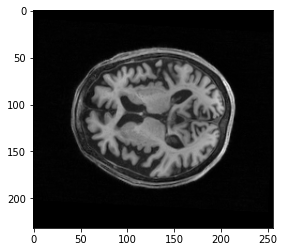

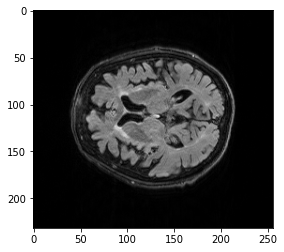

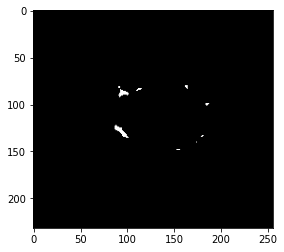

In [9]:
img_slice = img_t1[..., 20]
plt.imshow(img_slice, cmap='gray')
plt.show()

img_slice = img_flair[..., 20]
plt.imshow(img_slice, cmap='gray')
plt.show()

label_slice = label[..., 20]
plt.imshow(label_slice, cmap='gray')
plt.show()

## 3.3) Slice and load sliced images

Get volume images and slice and save

In [10]:
Country_Type_To_Output_Dir_Dict = {
    CountryDirType.Singapore: SINGAPORE_OUTPUT_DATA_DIR,
    CountryDirType.Utrecht: UTRECHT_OUTPUT_DATA_DIR,
    CountryDirType.Amsterdam: AMSTERDAM_OUTPUT_DATA_DIR
}

CREATE_SLICES = False

# Read and process image and label volumes
# Create Slices for dataset
if CREATE_SLICES: 
    for index, filedict in enumerate(data_dict):
        img_t1 = read_image_volume(filedict[DataDict.ImageT1], True)
        img_flair = read_image_volume(filedict[DataDict.ImageFlair], True)
        label = read_image_volume(filedict[DataDict.Label], False)
        subj_id = filedict[DataDict.Id]
        country_dir_type = filedict[DataDict.CountryDirType]
        output_country_dir = Country_Type_To_Output_Dir_Dict[country_dir_type]
        subject_slice_dir = os.path.join(output_country_dir, f'{subj_id}/')

        if path.exists(subject_slice_dir) == False:
            os.mkdir(subject_slice_dir)
            os.mkdir(subject_slice_dir + 'Image/')
            os.mkdir(subject_slice_dir + 'Image/T1/')
            os.mkdir(subject_slice_dir + 'Image/Flair/')
            os.mkdir(subject_slice_dir + 'Label/')

        out_dir_image = os.path.join(output_country_dir, f'{subj_id}/Image/')
        out_dir_image_t1 = os.path.join(output_country_dir, f'{subj_id}/Image/T1')
        out_dir_image_flair = os.path.join(output_country_dir, f'{subj_id}/Image/Flair')
        out_dir_label = os.path.join(output_country_dir, f'{subj_id}/Label/')

        num_slices_image_t1 = slice_and_save_volume_image(img_t1, f'brain_{str(subj_id)}', out_dir_image_t1)
        num_slices_image_flair = slice_and_save_volume_image(img_flair, f'brain_{str(subj_id)}', out_dir_image_flair)
        num_slices_label = slice_and_save_volume_image(label, f'brain_{str(subj_id)}', out_dir_label)

        if num_slices_image_t1 != num_slices_label & num_slices_image_flair != num_slices_label:
            raise ValueError(f'Image and Label dim not match: {img.shape}, {label.shape}')

        print(f'\n{filedict}, {num_slices_image_t1} slices created \n')


In [11]:
SINGAPORE_OUTPUT_DATA_PATHS = [f.path for f in os.scandir(SINGAPORE_OUTPUT_DATA_DIR) if f.is_dir()] 
UTRECHT_OUTPUT_DATA_PATHS = [f.path for f in os.scandir(UTRECHT_OUTPUT_DATA_DIR) if f.is_dir()] 
AMSTERDAM_OUTPUT_DATA_PATHS = [f.path for f in os.scandir(AMSTERDAM_OUTPUT_DATA_DIR) if f.is_dir()] 

# DATA_PATHS = SINGAPORE_OUTPUT_DATA_PATHS + UTRECHT_OUTPUT_DATA_PATHS + AMSTERDAM_OUTPUT_DATA_PATHS 
DATA_PATHS = SINGAPORE_OUTPUT_DATA_PATHS + UTRECHT_OUTPUT_DATA_PATHS 

Get slices and save into a list dicts

In [12]:
image_dict = []
ext_type = 'nii.gz'
img_extension = '.png'

for subject in DATA_PATHS:
    subj_id = int(os.path.basename(os.path.normpath(subject)))
    
    # # Temporary fix due to dim mismatch
    # if subj_id in [50, 51]:
    #     continue

    flair_imgs = sorted(glob.glob(f'{subject}/Image/Flair/*.{ext_type}'))
    t1_imgs = sorted(glob.glob(f'{subject}/Image/T1/*.{ext_type}'))
    labels = sorted(glob.glob(f'{subject}/Label/*.{ext_type}'))

    if len(flair_imgs) != len(t1_imgs):
        assert ValueError("Flair and T1 size mismatch")
    
    for i in range(len(flair_imgs)):
        slice_dict = {
            DataDict.Id: subj_id,
            DataDict.ImageFlair: flair_imgs[i],
            DataDict.ImageT1: t1_imgs[i],
            DataDict.Label: labels[i],
            DataDict.DepthZ: i
        }

        image_dict.append(slice_dict)

print(len(image_dict))
print(image_dict)

1920
[{'subj_id': 57, 'img_flair': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Slices/57/Image/Flair/brain_57-slice000_z.nii.gz', 'img_t1': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Slices/57/Image/T1/brain_57-slice000_z.nii.gz', 'label': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Slices/57/Label/brain_57-slice000_z.nii.gz', 'depth_z': 0}, {'subj_id': 57, 'img_flair': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Slices/57/Image/Flair/brain_57-slice001_z.nii.gz', 'img_t1': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Slices/57/Image/T1/brain_57-slice001_z.nii.gz', 'label': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Slices/57/Label/brain_57-slice001_z.nii.gz', 'depth_z': 1}, {'subj_id': 57, 'img_flair': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Slices/57/Image/Flair/brain_57-slice002_z.nii.gz', 'img_t1': '/content/drive/MyDrive/Brain Health In COVID 19/Singapore/Slices/57/Image/T1

## 3.3) Transforms

In [13]:
SEED = 2
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 64

In [14]:
class ImagesToMultiChannel(MapTransform):
    def __call__(self, data):
        to_concat_list = []
        for key in self.keys:
            to_concat_list.append(data[key])
            
        data[DataDict.Image] = torch.cat(to_concat_list, dim=0)
        return data

class Unsqueeze(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            data[key] = torch.unsqueeze(data[key], dim=0)
            
        return data
        

class TestShape(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            print(f'{key}: \t{data[key].shape}')
            
        return data

class ResizeCentre(MapTransform):
    def __init__(self, keys, dims):
        super().__init__(keys=keys)
        self.dims = dims

    def __call__(self, data):
        print(f'dimensions are {self.dims}')
        for key in self.keys:
            print(f'before {data[key].shape}')
            data[key] = resize_center(data[key], *self.dims)
            print(f'after {data[key].shape}')
            
        return data
        

# normalize_img_intensity_range
class NormalizeIntensitydCustom(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            data[key] = normalize_img_intensity_range(data[key])
            
        return data

class ConvertToMultiChannelBasedOnLabelsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the WMH

    """

    def __call__(self, data):
        d = dict(data)
        
        for key in self.keys:
            result = []
            
            d[key] = np.squeeze(d[key])

            # Other labels and background merge as backgrounds
            result.append(np.logical_or(d[key] == 0, d[key] == 2))
            # result.append(d[key] == 0)
            result.append(d[key] == 1)

            d[key] = np.stack(result, axis=0).astype(np.float32)
            
        return d

In [15]:
train_transform = Compose(
    [
        LoadImaged(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label]),
        AddChanneld(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label]),
        ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        Spacingd(
            keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "bilinear", "nearest"),
        ),
        Resized(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label], spatial_size=[256, 256]), 
        Orientationd(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label], axcodes="RAS"),
        RandFlipd(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label], prob=0.5, spatial_axis=0),
        # TestShape(keys=[DataDict.ImageT1, DataDict.ImageFlair]),
        # NormalizeIntensitydCustom(keys=[DataDict.ImageT1, DataDict.ImageFlair]),
        # NormalizeIntensityd(keys=[DataDict.ImageT1, DataDict.ImageFlair], nonzero=True, channel_wise=True),
        Rand2DElasticd(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label], spacing=(30, 40), magnitude_range=(0.8, 1.2), prob=0.3),
        RandScaleIntensityd(keys=[DataDict.ImageT1, DataDict.ImageFlair], factors=0.1, prob=0.5),
        RandShiftIntensityd(keys=[DataDict.ImageT1, DataDict.ImageFlair], offsets=0.1, prob=0.5),
        RandZoomd(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label], prob=1.0, min_zoom=0.9, max_zoom=1.1),
        ToTensord(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label]),
        ImagesToMultiChannel(keys=[DataDict.ImageT1, DataDict.ImageFlair]), 
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label]),
        AddChanneld(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label]),
        ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        Spacingd(
            keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "bilinear", "nearest"),
        ),
        Resized(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label], spatial_size=[256, 256]), 
        Orientationd(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label], axcodes="RAS"),
        # NormalizeIntensityd(keys=[DataDict.ImageT1, DataDict.ImageFlair], nonzero=True, channel_wise=True),
        ToTensord(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label]),
        ImagesToMultiChannel(keys=[DataDict.ImageT1, DataDict.ImageFlair]), 
    ]
)

test_transform = Compose(
    [
        LoadImaged(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label]),
        AddChanneld(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label]),
        ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        Spacingd(
            keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "bilinear", "nearest"),
        ),
        Resized(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label], spatial_size=[256, 256]), 
        Orientationd(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label], axcodes="RAS"),
        # NormalizeIntensityd(keys=[DataDict.ImageT1, DataDict.ImageFlair], nonzero=True, channel_wise=True),
        ToTensord(keys=[DataDict.ImageT1, DataDict.ImageFlair, DataDict.Label]),
        ImagesToMultiChannel(keys=[DataDict.ImageT1, DataDict.ImageFlair]), 
    ]
)


## 3.5) Dataset and Dataloader

In [16]:
data_paths = image_dict
unique_subj_id = list(set(list(v[DataDict.Id] for v in data_paths)))

validation_split = 0.2
shuffle_dataset = True

dataset_size_subj = len(unique_subj_id)
# indices = list(range(dataset_size_subj))
split = int(np.floor(validation_split * dataset_size_subj))

print(unique_subj_id)
if shuffle_dataset :
    np.random.seed(SEED)
    np.random.shuffle(unique_subj_id)

train_subjs, val_subjs = unique_subj_id[split:], unique_subj_id[:split]
train_paths, val_paths = get_dicts_from_dicts(data_paths, DataDict.Id, train_subjs), get_dicts_from_dicts(data_paths, DataDict.Id, val_subjs)

train_dataset  = Dataset(train_paths, train_transform)
validation_dataset  = Dataset(val_paths, val_transform)
test_dataset = Dataset(val_paths, test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)

print(unique_subj_id)
print(train_subjs)
print(val_subjs)

[0, 2, 4, 6, 8, 11, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[57, 23, 33, 0, 4, 60, 31, 66, 39, 67, 68, 59, 54, 29, 37, 2, 63, 53, 55, 49, 62, 25, 8, 17, 6, 64, 11, 58, 50, 56, 69, 51, 65, 61, 19, 27, 41, 52, 21, 35]
[39, 67, 68, 59, 54, 29, 37, 2, 63, 53, 55, 49, 62, 25, 8, 17, 6, 64, 11, 58, 50, 56, 69, 51, 65, 61, 19, 27, 41, 52, 21, 35]
[57, 23, 33, 0, 4, 60, 31, 66]


12
6
tensor([[[-0.0236, -0.0236, -0.0236,  ..., -0.0236, -0.0236, -0.0236],
         [-0.0236, -0.0236, -0.0236,  ..., -0.0236, -0.0236, -0.0236],
         [-0.0236, -0.0236, -0.0236,  ..., -0.0236, -0.0236, -0.0236],
         ...,
         [-0.0236, -0.0236, -0.0236,  ..., -0.0234, -0.0234, -0.0234],
         [-0.0236, -0.0236, -0.0236,  ..., -0.0234, -0.0234, -0.0234],
         [-0.0236, -0.0236, -0.0236,  ..., -0.0234, -0.0234, -0.0234]]])

Shapes: Image torch.Size([2, 256, 256]) 	Flair torch.Size([1, 256, 256])	T1 torch.Size([1, 256, 256])	Label torch.Size([2, 256, 256])
tensor(-0.0236)
tensor(0.5660)


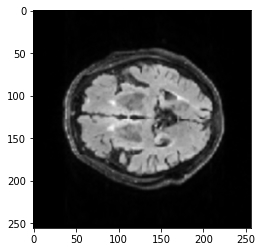

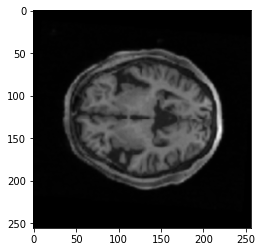

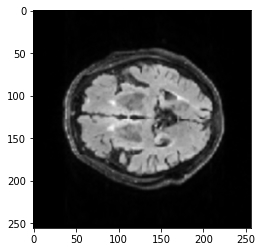

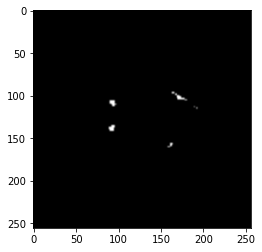

In [17]:
print(len(train_loader))
print(len(validation_loader))

sample_data = train_dataset.__getitem__(20)
sample_tensor_image, sample_tensor_flair, sample_tensor_t1, sample_tensor_label = sample_data[DataDict.Image], sample_data[DataDict.ImageFlair], sample_data[DataDict.ImageT1], sample_data[DataDict.Label]

print(f'{sample_tensor_flair}\n')
print(f'Shapes: Image {sample_tensor_image.shape} \tFlair {sample_tensor_flair.shape}\tT1 {sample_tensor_t1.shape}\tLabel {sample_tensor_label.shape}')

print(torch.min(sample_tensor_t1))
print(torch.max(sample_tensor_t1))

plt.imshow(sample_tensor_flair.squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image[0].squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image[1].squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_label[1].squeeze().detach().cpu() , cmap='gray')
plt.show()

tensor([[[-0.0236, -0.0236, -0.0236,  ..., -0.0236, -0.0236, -0.0236],
         [-0.0236, -0.0236, -0.0236,  ..., -0.0236, -0.0236, -0.0236],
         [-0.0236, -0.0236, -0.0236,  ..., -0.0236, -0.0236, -0.0236],
         ...,
         [-0.0236, -0.0236, -0.0236,  ..., -0.0234, -0.0234, -0.0234],
         [-0.0236, -0.0236, -0.0236,  ..., -0.0234, -0.0234, -0.0234],
         [-0.0236, -0.0236, -0.0236,  ..., -0.0234, -0.0234, -0.0234]]])

Shapes: Image torch.Size([2, 256, 256]) 	Flair torch.Size([1, 256, 256])	T1 torch.Size([1, 256, 256])	Label torch.Size([2, 256, 256])


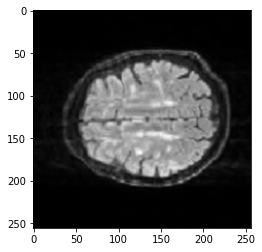

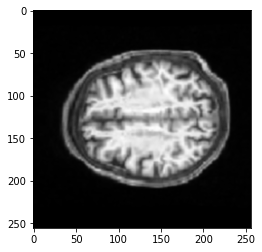

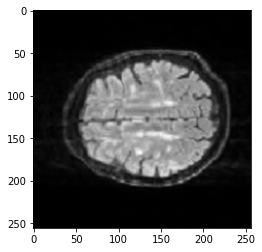

In [18]:
sample_data_2 = train_dataset.__getitem__(320)
sample_tensor_image2, sample_tensor_flair2, sample_tensor_t12, sample_tensor_label2 = sample_data_2[DataDict.Image], sample_data_2[DataDict.ImageFlair], sample_data_2[DataDict.ImageT1], sample_data_2[DataDict.Label]

print(f'{sample_tensor_flair}\n')
print(f'Shapes: Image {sample_tensor_image2.shape} \tFlair {sample_tensor_flair2.shape}\tT1 {sample_tensor_t12.shape}\tLabel {sample_tensor_label2.shape}')
plt.imshow(sample_tensor_flair2.squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image2[0].squeeze().detach().cpu() , cmap='gray')
plt.show()
plt.imshow(sample_tensor_image2[1].squeeze().detach().cpu() , cmap='gray')
plt.show()

# 4) Network

## 4.1) Train Network

In [19]:
def train_network(training_loader, val_loader, network, loss_fun, optimizer, EPOCHS=200, pre_load_training=False, checkpoint_name=''):
    network.cuda(device)
 
    optimizer = optimizer
    loss_fun = loss_fun 

    epoch_checkpoint = 0

    losses = {}
    val_losses = {}
    
    # Test Learning rate dictionary for visualization
    scheduler_learning_rate_dict = {}

    if pre_load_training:
        checkpoint = torch.load(ROOT_DIR + f'{checkpoint_name}.pt')
        epoch_checkpoint = checkpoint['epoch'] + 1
        network.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        loss = checkpoint['loss']
        losses = checkpoint['losses']
        val_losses = checkpoint['val_losses']
        # learning_rate = checkpoint['learning_rate'] if 'learning_rate' in checkpoint.keys() else optimizer.param_groups[0]["lr"]
    
    # if epoch_checkpoint > 300:
    #     print(f'Learning rate changed from {optimizer.param_groups[0]["lr"]} to:')
    #     optimizer.param_groups[0]["lr"] = 0.0001
    #     print(f'{optimizer.param_groups[0]["lr"]}')

    # Train the network
    for epoch in range(epoch_checkpoint, EPOCHS):
        network.train(True)

        print(f'losses: {losses}')
        print(f'val losses {val_losses}')
        
        train_step = 1
        batch_loss = []

        for batch_data in training_loader:
            print(f'Epoch {epoch}\tTraining Step: {train_step}/{len(training_loader)}')

            torch.cuda.empty_cache() # Clear any unused variables
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"] # Only pass to CUDA when required - preserve memory
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Feed input data into the network to train
            outputs = network(inputs)
            
            # Input no longer in use for current iteration - clear from CUDA memory
            inputs = inputs.cpu()
            torch.cuda.empty_cache()
            
            # labels to CUDA
            labels = batch_data["label"].to(device)
            torch.cuda.empty_cache()

            # Calculate DICE CE loss, permute tensors to correct dimensions
            loss = loss_fun(outputs, labels)

            # List of losses for current batch
            batch_loss.append(loss.detach().cpu().numpy())
            
            # Clear CUDA memory
            labels = labels.cpu()
            torch.cuda.empty_cache()
            
            # Backward pass
            loss.backward()
            
            # Optimize
            optimizer.step()

            train_step += 1

        # Get average loss for current batch
        losses[epoch] = np.mean(batch_loss)
        print(f'train losses {batch_loss} \nmean loss {losses[epoch]}')
        
        if epoch % 2 == 0:
            # Set network to eval mode
            network.train(False)
            # Disiable gradient calculation and optimise memory 
            with torch.no_grad():
                # Initialise validation loss
                dice_test_loss = 0
                val_iter_count = 0
                # dice_test_loss = []
                for i, batch_data in enumerate(val_loader):
                    # Get inputs and labels from validation set
                    inputs = batch_data["image"].to(device)
                    labels = batch_data["label"]

                    outputs = network(inputs)

                    # Memory optimization
                    inputs = inputs.cpu()
                    torch.cuda.empty_cache()
                    labels = batch_data["label"].to(device)

                    # Accumulate DICE CE loss validation error
                    test_loss = loss_fun(outputs, labels)
                    dice_test_loss += test_loss
                    # dice_test_loss += loss_fun(outputs, labels)
                    val_iter_count += 1
                    print(f'Val loss iter {i}: {test_loss}')

                # Get average validation DICE CE loss
                val_losses[epoch] = dice_test_loss / val_iter_count
              
                # Print errors 
                print(
                    "==== Epoch: " + str(epoch) + 
                    " | DICE loss: " + str(numpy_from_tensor((dice_test_loss) / val_iter_count)) +
                    " | Total Loss: " + str(numpy_from_tensor((dice_test_loss) / val_iter_count))+ " =====") # This is redundant code but will keep here incase we add more losses
                
                # View slice at halfway point
                half = outputs.shape[2] // 2
                
                # Show predictions for current iteration
                print(f'shape is {inputs.shape}')
                view_slice(numpy_from_tensor(inputs[0, 0, :, :]), f'Input Channel 0 Image Epoch {epoch}', gray=True)
                view_slice(numpy_from_tensor(inputs[0, 1, :, :]), f'Input Channel 1 Image Epoch {epoch}', gray=True)
                view_slice(numpy_from_tensor(outputs[0, 1, :, :]), f'WMH Output Image Epoch {epoch}', gray=True)
                view_slice(numpy_from_tensor(labels[0, 1, :, :]), f'WMH Labels  Epoch {epoch}', gray=True)
        
        # Save training checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'losses': losses,
            'val_losses': val_losses,
            # 'learning_rate': optimizer.param_groups[0]['lr']
            # 'scheduler_learning_rate_dict':scheduler_learning_rate_dict
        }, ROOT_DIR + f'{checkpoint_name}.pt')

        # Confirm current epoch trained params are saved 
        print(f'Saved for epoch {epoch}')

    return network

## 4.2) Initialise network params

In [20]:
class UNet(UNet):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = super().forward(x)
        x = F.softmax(x)
        return x

In [21]:
device = torch.device("cuda")
model = UNet(
    dimensions=2,
    in_channels=2,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.2,
    # kernel_size=3,
).to(device)

loss_function = DiceLoss()

optimizer = torch.optim.Adam(
    model.parameters(), 1e-3, weight_decay=1e-5, amsgrad=True, 
)

from torchvision import models
from torchsummary import summary

summary(model, (2, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             304
            Conv2d-2         [-1, 16, 128, 128]             304
    InstanceNorm2d-3         [-1, 16, 128, 128]               0
           Dropout-4         [-1, 16, 128, 128]               0
             PReLU-5         [-1, 16, 128, 128]               1
            Conv2d-6         [-1, 16, 128, 128]           2,320
    InstanceNorm2d-7         [-1, 16, 128, 128]               0
           Dropout-8         [-1, 16, 128, 128]               0
             PReLU-9         [-1, 16, 128, 128]               1
     ResidualUnit-10         [-1, 16, 128, 128]               0
           Conv2d-11           [-1, 32, 64, 64]           4,640
           Conv2d-12           [-1, 32, 64, 64]           4,640
   InstanceNorm2d-13           [-1, 32, 64, 64]               0
          Dropout-14           [-1, 32,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


## 4.3) Train data

losses: {0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 0.39340973, 64: 0.39

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Epoch 324	Training Step: 2/12
Epoch 324	Training Step: 3/12
Epoch 324	Training Step: 4/12
Epoch 324	Training Step: 5/12
Epoch 324	Training Step: 6/12
Epoch 324	Training Step: 7/12
Epoch 324	Training Step: 8/12
Epoch 324	Training Step: 9/12
Epoch 324	Training Step: 10/12
Epoch 324	Training Step: 11/12
Epoch 324	Training Step: 12/12
train losses [array(0.35859102, dtype=float32), array(0.36516446, dtype=float32), array(0.36704236, dtype=float32), array(0.3539304, dtype=float32), array(0.3398105, dtype=float32), array(0.3674932, dtype=float32), array(0.35276735, dtype=float32), array(0.34392744, dtype=float32), array(0.35337362, dtype=float32), array(0.37309268, dtype=float32), array(0.38162804, dtype=float32), array(0.36371917, dtype=float32)] 
mean loss 0.3600449860095978
Val loss iter 0: 0.3778698146343231
Val loss iter 1: 0.3468499183654785
Val loss iter 2: 0.3590134382247925
Val loss iter 3: 0.3217266798019409
Val loss iter 4: 0.3477291464805603
Val loss iter 5: 0.3900805115699768
==

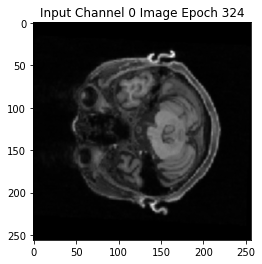

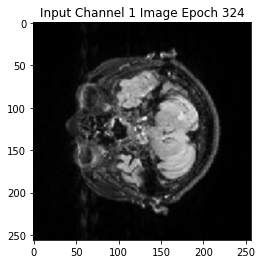

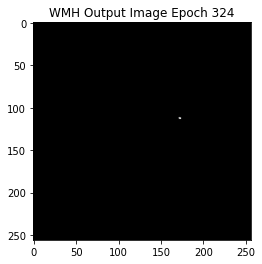

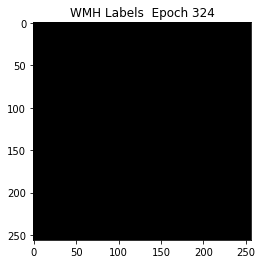

Saved for epoch 324
losses: {0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 

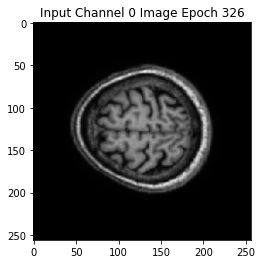

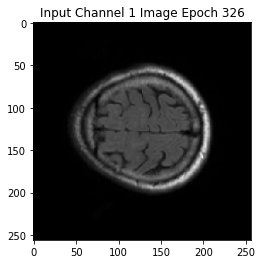

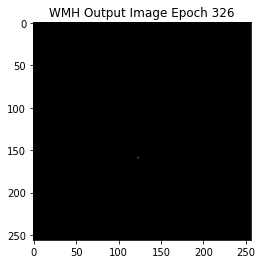

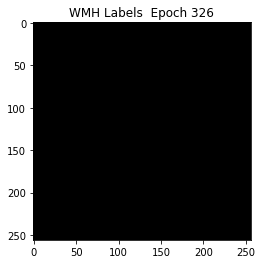

Saved for epoch 326
losses: {0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 

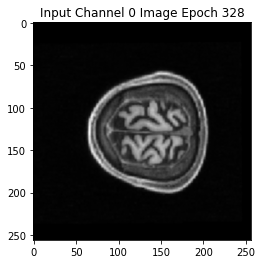

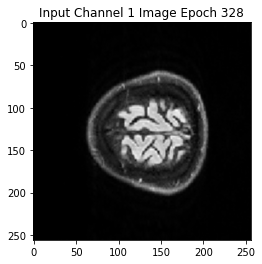

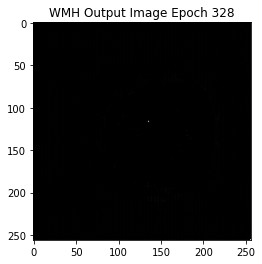

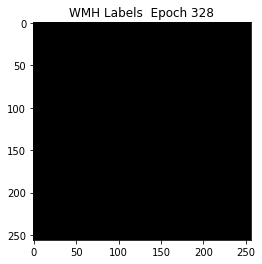

Saved for epoch 328
losses: {0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 

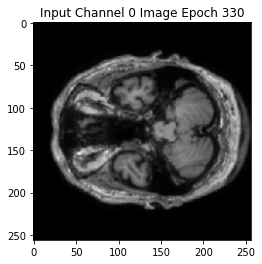

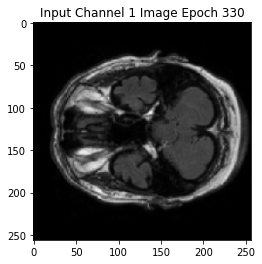

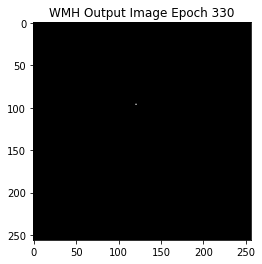

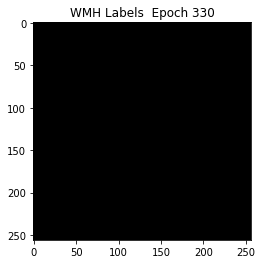

Saved for epoch 330
losses: {0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 

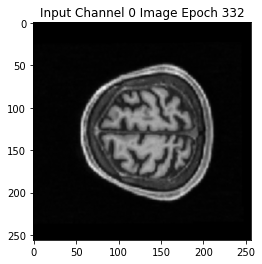

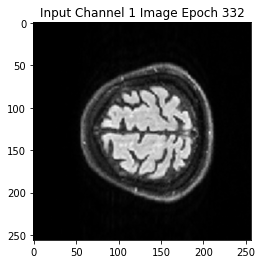

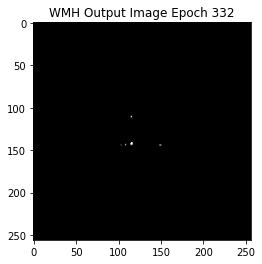

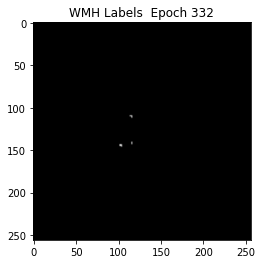

Saved for epoch 332
losses: {0: 0.6233169, 1: 0.6009359, 2: 0.58875245, 3: 0.57873124, 4: 0.57001907, 5: 0.5625568, 6: 0.55614454, 7: 0.5505168, 8: 0.54531723, 9: 0.540313, 10: 0.534805, 11: 0.52773863, 12: 0.51942563, 13: 0.5110327, 14: 0.5051068, 15: 0.50063014, 16: 0.49556315, 17: 0.4912256, 18: 0.48745945, 19: 0.48369727, 20: 0.48038015, 21: 0.47716114, 22: 0.47323546, 23: 0.46955952, 24: 0.46631345, 25: 0.46425438, 26: 0.4598975, 27: 0.4562563, 28: 0.45297328, 29: 0.4504048, 30: 0.44727048, 31: 0.44476578, 32: 0.44116664, 33: 0.43913487, 34: 0.436723, 35: 0.43393457, 36: 0.43151307, 37: 0.4284356, 38: 0.42671946, 39: 0.4242736, 40: 0.42306963, 41: 0.42174378, 42: 0.4178804, 43: 0.4164754, 44: 0.41513374, 45: 0.4147267, 46: 0.41267958, 47: 0.41021934, 48: 0.4084485, 49: 0.4073101, 50: 0.40543148, 51: 0.4035108, 52: 0.40463927, 53: 0.4032588, 54: 0.4005791, 55: 0.4001834, 56: 0.39903, 57: 0.3991489, 58: 0.39906025, 59: 0.39697325, 60: 0.39621043, 61: 0.39561367, 62: 0.39355302, 63: 

In [ ]:
net = train_network(training_loader=train_loader, val_loader=validation_loader, network=model, 
                    loss_fun=loss_function, optimizer=optimizer, EPOCHS=2000, pre_load_training=True, checkpoint_name='unet_brain_wmi_UbSi_new_norm')

# 5) Test network

In [ ]:
# Load the network for testing
pred_network = model

checkpoint = torch.load(ROOT_DIR + '/unet_brain_wmi_UbSi_new_norm.pt')
epoch_checkpoint = checkpoint['epoch']
losses = checkpoint['losses']
val_losses = checkpoint['val_losses']
pred_network.load_state_dict(checkpoint['model_state_dict'])

# print(checkpoint['model_state_dict'])
print(epoch_checkpoint)
print(losses)
print(val_losses)



In [ ]:

print(losses)
print(val_losses)


# Plot the validation and training losses
print(val_losses)
val_tensors = dict_tensor_to_value(val_losses)
print(val_tensors)

training_losses = sorted(losses.items()) # sorted by key, return a list of tuples
x, y = zip(*training_losses) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

validation_losses = sorted(val_tensors.items())
x2, y2 = zip(*validation_losses) # unpack a list of pairs into two tuples

plt.plot(x2, y2)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(x, y, label = "Training")
plt.plot(x2, y2, label = "Validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from torchvision import models
from torchsummary import summary

summary(pred_network, (2, 256, 256))

# 6) Test Whole Volume

In [ ]:
class ImagePredictor():
    def __init__(self, model, dataset):
        self.model = model
        # Passed as 2D slices with information about depth for reconstruction
        self.dataset = dataset

    def predict(self):
        self.slice_predictions = []
        with torch.no_grad():
            self.model.eval()
            pred_count = 1

            for data in self.dataset:
                if pred_count == 1 or pred_count % 50 == 0 or pred_count == len(self.dataset):
                    print(f'Predicting {pred_count}/{len(self.dataset)} slices')
                image = data[DataDict.Image]
                label = data[DataDict.Label]
                subj_id = data[DataDict.Id]
                depth_z = data[DataDict.DepthZ]

                image = image.unsqueeze(dim=0)
                image = image.to(device)

                output = one_hot(self.model(image))

                self.slice_predictions.append({
                    DataDict.Id: subj_id,
                    DataDict.DepthZ: depth_z,
                    DataDict.Label: label,
                    DataDict.Prediction: output
                })

                # print(self.slice_predictions)

                pred_count += 1
                

    def predict_handler(self):
        # Predict all slices
        self.predict()
        self.volume_predictions = []

        subj_ids = list(set(list(v[DataDict.Id] for v in self.slice_predictions)))

        print(f'{len(subj_ids)} subjects to predict')
        pred_count = 1
        # For all subjects
        for subject_id in subj_ids:
            print(f'Reconstructing {pred_count}/{len(subj_ids)}')
            # Find all slice_predictions by subjects
            subject_predictions = get_dicts_from_dicts(self.slice_predictions, DataDict.Id, [subject_id])
          
            # Reconstruct volume by subject
            volume_prediction, volume_label = self.reconstruct(subject_predictions)
        
            self.volume_predictions.append({
                DataDict.Id: subject_id,
                DataDict.Prediction: volume_prediction,
                DataDict.Label: volume_label
            })

            pred_count += 1

        return self.volume_predictions

    def reconstruct(self, subj_predictions):
        # sorted_subbj_pred_by_depth = sorted(subj_predictions, key=itemgetter(DataDict.DepthZ))     
        z_length = len(subj_predictions)  
        prediction_volume = torch.zeros((256, 256, z_length))
        label_volume = torch.zeros((256, 256, z_length))
        subj_id = subj_predictions[0][DataDict.Id]

        for i in range(z_length):
            # only take second channel
            if subj_predictions[i][DataDict.DepthZ] != i:
                raise ValueError("Reconstruction error: Slice missing") 

            subj_slice = subj_predictions[i] 
            # print(f'slice prediction {subj_slice[DataDict.Prediction].shape}')
            # print(f'slice label {subj_slice[DataDict.Label].shape}')
            prediction_volume[..., i] = subj_slice[DataDict.Prediction][0, 1, ...]
            label_volume[..., i] = subj_slice[DataDict.Label][1]

        return prediction_volume, label_volume

In [ ]:
# test_datasaet
img_predictor = ImagePredictor(pred_network, test_dataset)
test_predictions = img_predictor.predict_handler()
print('DONE')

In [ ]:
len(test_predictions)

In [ ]:
from monai.metrics import compute_meandice, DiceMetric

dice_scores = []

for i in range(len(test_predictions)):
    test_subject_prediction = test_predictions[i]

    print(test_subject_prediction[DataDict.Label].shape)
    print(test_subject_prediction[DataDict.Prediction].shape)

    pred = test_subject_prediction[DataDict.Prediction]
    label = test_subject_prediction[DataDict.Label]

    print(torch.max(pred))
    print(torch.min(pred))

    dice_metric = DiceLoss()
    # print(compute_meandice(pred, label))
    dice_score = 1 - dice_metric(pred, label)

    dice_scores.append(dice_score.item())


In [ ]:
dice_scores


In [ ]:
from numpy import mean
mean_dice_score = round(mean(dice_scores), 5) 
mean_dice_score

In [ ]:
# view_slice(numpy_from_tensor(inputs[0, 0, :, :]), f'Input Channel 0 Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(inputs[0, 1, :, :]), f'Input Channel 1 Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(outputs[0, 1, :, :]), f'WMH Output Image Epoch {epoch}', gray=True)
# view_slice(numpy_from_tensor(pred[..., 25]), f'WMH Pred', gray=True)
# view_slice(numpy_from_tensor(label[..., 25]), f'WMH Labels', gray=True)

w = 200
h = 200
fig = plt.figure(figsize=(200, 600))
fig.set_figheight(h)
fig.set_figwidth(w)
columns = 8
rows = 12

label_count = 0
pred_count = 0
row = 1

for i in range(1, columns * rows + 1):  
    fig.add_subplot(rows, columns, i)
    # Prediction row
    if row % 2 != 0:
        plt.subplot(rows, columns, i).set_title(f'Prediction Depth {pred_count}', fontweight="bold", size=80)
        plt.imshow(pred[..., pred_count], cmap='gray')
        pred_count += 1
    # Label row
    else:
        plt.subplot(rows, columns, i).set_title(f'Label Depth {label_count}', fontweight="bold", size=80)
        plt.imshow(label[..., label_count], cmap='gray')
        label_count += 1

    
    row += 1 if i % 8 == 0 else 0
plt.show()